## Importing libraries and modules

In [7]:
import re #regular expression operations
import random #generate pseudo random numbers
import numpy as np #array operations
from nltk.tokenize import word_tokenize #tokenizer -> converts string to tokens
from keras.callbacks import History
import matplotlib.pyplot as plt
import tensorflow as tf
# modules needed for building seq2seq model
from tensorflow import keras # Keras is an open-source library that provides a Python interface for artificial neural networks.
from keras.layers import Input # Layer to be used as an entry point into a Network (a graph of layers).
from keras.layers import LSTM # Long Short-Term Memory layer
from keras.layers import Dense # regular densely-connected NN layer.
from keras.models import Model # Model groups layers into an object with training and inference features.
from keras.models import load_model # Loads a model saved via model.save()

## Data Preprocessing

In [8]:
# Opening the data files . We have two separate .txt files which stores human_responses and bot_responses
# l1 contains human_responses , l2 contains bot_responses
# UTF-8 is one of the most commonly used encodings, and Python often defaults to using it.
with open(r'human_responses_1084.txt',encoding='utf-8') as file: 
    l1 = file.read().split('\n') #splitting at newline  
with open(r'bot_responses_1084.txt',encoding='utf-8') as file:
    l2 = file.read().split('\n') #splitting at newline
    
# Here we are using regular expressions to remove punctuations (except comma), special symbols
# We keep comma because it helps to separate multiple proper nouns
# Converting whole sentences to lower case to reduce ambiguity
l1 = [re.sub('[^,a-zA-Z0-9 \n]', '', x) for x in l1]
l1 = [x.lower() for x in l1]
l2 = [re.sub('[^,a-zA-Z0-9 \n]', '', x) for x in l2]
l2 = [x.lower() for x in l2]

# zip produces a tuple of (human_response,bot_response)
# then we convert it into a list of tuples
lis = list(zip(l1,l2))

# Finding all unique input tokens
HumanResponses = [] #stores the human responses as a list - also our input lines
InputTokens = set() #stores unique input tokens . We took a set because set has the feature of storing all unique elements
for y in lis:
    a = y[0] #y[0]->human
    # Spacing words from punctuation (so that comma can be treated as an unique token)
    # basically finds all unique tokens and appends them with spaces in between
    a = " ".join(re.findall(r"[\w']+|[^\s\w]", a))
    # Appending each human side sentence to human_responses
    HumanResponses.append(a)
    # Now we tokenize each sentence into tokens and add each unique token to our token set
    # We are using word_tokenize() from NLTK
    for t in word_tokenize(a):
        if t not in InputTokens:
            InputTokens.add(t)
InputTokens = sorted(list(InputTokens)) # converting set to list and sorting it in alphabetical order
EncoderTokenLen = len(InputTokens) #no of input tokens

# Finding all unique output tokens
BotResponses = [] #stores the bot responses as a list - also our output lines
OutputTokens = set() #stores unique output tokens. We took a set because set has the feature of storing all unique elements
for y in lis:
    a = y[1] #y[1]->bot
    # Spacing words from punctuation (so that comma can be treated as an unique token)
    # basically finds all unique tokens and appends them with spaces in between
    a = " ".join(re.findall(r"[\w']+|[^\s\w]", a))
    # Manipulating a by adding tracker tokens (<START> & <STOP>) and appending it to bot_responses
    # START -> helps the decoder to know what is the starting of a sentence
    # STOP -> helps the decoder to know that is the ending of a sentence
    a = 'START ' + a + ' STOP'
    BotResponses.append(a)
    # Now we tokenize each sentence into tokens and add each unique token to our token set
    # We are using word_tokenize() from NLTK
    for t in word_tokenize(a):
        if t not in OutputTokens:
            OutputTokens.add(t)
OutputTokens = sorted(list(OutputTokens))
DecoderTokenLen = len(OutputTokens) #no of output tokens

## Vectorization

In [14]:
# enumerate is a function which returns the count/index of elements in a list along with the elements
# Feature dictionaries will help us to vectorize text (process of converting text into numerical representation) . We will use one-hot vectorization
# Reverse feature dictionaries will help us to reverse vectorize text (process of converting vectorized text to text)
# Dictionary containing pairs in the format (key : token , value : index) for the input vocabulary
InputFeatures_Dict = {}
for i,t in enumerate(InputTokens):
    InputFeatures_Dict.update({t:i})
# Dictionary containing pairs in the format (key : index , value : token) for the input vocabulary . Reverse of input features dict
RevInputFeatures_Dict = {}
for i,t in enumerate(InputTokens):
    RevInputFeatures_Dict.update({i:t})
# Dictionary containing pairs in the format (key : token , value : index) for the output vocabulary
OutputFeatures_Dict = {}
for i,t in enumerate(OutputTokens):
    OutputFeatures_Dict.update({t:i})
# Dictionary containing pairs in the format (key : index , value : token) for the output vocabulary . Reverse of output features dict
RevOutputFeatures_Dict = {}
for i,t in enumerate(OutputTokens):
    RevOutputFeatures_Dict.update({i:t})

#Maximum no of tokens in a single sentence in input and output documents. Basically helps in padding
MaxEncoder_Len = 0
for x in HumanResponses:
    MaxEncoder_Len = max(len(word_tokenize(x)),MaxEncoder_Len)
MaxDecoder_Len = 0
for x in BotResponses:
    MaxDecoder_Len = max(len(word_tokenize(x)),MaxDecoder_Len)


# We will make use of 3 matrices EncoderInput_data, DecoderInput_data, DecoderOutput_data. (Encoder output is nothing but the decoder input)
# The reason we are using two matrices for the Decoder is a method called teacher forcing which is used by the seq2seq model while training.
# TEACHER FORCING - https://towardsdatascience.com/what-is-teacher-forcing-3da6217fed1c

# One-hot vectorization taking place
# 3D matrix - total no of sentences x max token length of a sentence from the corpus x total no of unique tokens

# Filling EncoderInput_data
EncoderInput_data = np.zeros((len(HumanResponses), MaxEncoder_Len, EncoderTokenLen),dtype='float32')
for l,(a,b) in enumerate(zip(HumanResponses,BotResponses)): # returns a tuple along with index
    for ts,t in enumerate(word_tokenize(a)): # human responses are the encoder input
        # Assign 1.0 for the current sentence, timestep, & token in EncoderInput_data
        # l -> sentence number, ts -> timestep, InputFeatures_Dict[t] -> index value of the token t which was extracted from unique token list
        EncoderInput_data[l,ts,InputFeatures_Dict[t]] = 1.0
        
# Filling DecoderInput_data        
DecoderInput_data = np.zeros((len(BotResponses), MaxDecoder_Len, DecoderTokenLen),dtype='float32')
for l,(a,b) in enumerate(zip(HumanResponses,BotResponses)): # returns a tuple along with index
    for ts,t in enumerate(word_tokenize(b)):
        # Assign 1.0 for the current sentence, timestep, & token in DecoderInput_data
        # l -> sentence number, ts -> timestep, InputFeatures_Dict[t] -> index value of the token t which was extracted from unique token list
        DecoderInput_data[l,ts,OutputFeatures_Dict[t]] = 1.0
        
# Filling DecoderOutput_data
DecoderOutput_data = np.zeros((len(BotResponses), MaxDecoder_Len, DecoderTokenLen),dtype='float32')
for l,(a,b) in enumerate(zip(HumanResponses,BotResponses)): # returns a tuple along with index
    for ts,t in enumerate(word_tokenize(b)):
        if ts > 0:
            # DecoderOutput_data helps us in implementing teacher forcing
            DecoderOutput_data[l,ts-1,OutputFeatures_Dict[t]] = 1.0

## Training

In [16]:
        
#Dimensionality -> no of LSTM units
dimensionality = 512 
#The batch size and number of epochs
batch_size = 10
epochs = 50
#Encoder
EncoderInput = Input(shape=(None,EncoderTokenLen)) 
EncoderLSTM = LSTM(dimensionality, return_state=True)
EncoderOutput,HiddenState_En,StateCell_En = EncoderLSTM(EncoderInput)
EncoderStates = [HiddenState_En,StateCell_En]
#Decoder
DecoderInput = Input(shape=(None,DecoderTokenLen))
DecoderLSTM = LSTM(dimensionality, return_sequences=True, return_state=True)
DecoderOutput,HiddenState_De,StateCell_De = DecoderLSTM(DecoderInput,initial_state=EncoderStates)
DecoderDense = Dense(DecoderTokenLen,activation='softmax')
DecoderOutput = DecoderDense(DecoderOutput)

#Model
Train_model = Model([EncoderInput,DecoderInput], DecoderOutput)
#Compiling
Train_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'], sample_weight_mode='temporal')
#Training
history = History()
Train_model.fit([EncoderInput_data,DecoderInput_data],DecoderOutput_data,batch_size = batch_size,epochs = epochs,validation_split = 0.2, shuffle=False,callbacks=[history])
Train_model.save('Train_model.h5')

Train on 867 samples, validate on 217 samples
Epoch 1/50
867/867 [==============================] - 6s 7ms/step - loss: 1.3074 - accuracy: 0.6437 - val_loss: 1.3355 - val_accuracy: 0.7737
Epoch 2/50
867/867 [==============================] - 6s 7ms/step - loss: 1.1706 - accuracy: 0.6929 - val_loss: 1.2299 - val_accuracy: 0.7744
Epoch 3/50
867/867 [==============================] - 6s 7ms/step - loss: 1.0785 - accuracy: 0.7820 - val_loss: 1.1386 - val_accuracy: 0.7776
Epoch 4/50
867/867 [==============================] - 6s 7ms/step - loss: 0.9882 - accuracy: 0.7823 - val_loss: 1.0417 - val_accuracy: 0.7661
Epoch 5/50
867/867 [==============================] - 6s 6ms/step - loss: 0.8602 - accuracy: 0.7764 - val_loss: 0.9056 - val_accuracy: 0.7494
Epoch 6/50
867/867 [==============================] - 6s 7ms/step - loss: 0.6848 - accuracy: 0.7276 - val_loss: 0.6923 - val_accuracy: 0.7564
Epoch 7/50
867/867 [==============================] - 6s 7ms/step - loss: 0.5088 - accuracy: 0.6178 - 

## Testing

In [17]:
Train_model = load_model('Train_model.h5')
EncoderInput = Train_model.input[0]
EncoderOutput,state_h_En,state_c_En = Train_model.layers[2].output
EncoderStates = [state_h_En, state_c_En]
EncoderModel = Model(EncoderInput,EncoderStates)

latent_dim = 512
DecoderStateInput_hid = Input(shape=(latent_dim,))
DecoderStateInput_cell = Input(shape=(latent_dim,))
DecoderStateInput = [DecoderStateInput_hid,DecoderStateInput_cell]

DecoderOutput,HiddenState_En,StateCell_En = DecoderLSTM(DecoderInput,initial_state=DecoderStateInput)
DecoderState = [HiddenState_En,StateCell_En]
DecoderOutput = DecoderDense(DecoderOutput)

DecoderModel = Model([DecoderInput] + DecoderStateInput,[DecoderOutput] + DecoderState)


negative_word = ("no", "nope", "nah", "naw", "not a chance", "sorry", "never") # list of negative responses
exit_word = ("quit", "pause", "exit", "goodbye", "bye", "later", "stop") # list of exit cues
exclamation_word = ("okay","thanks","thank you","okay nice","okay nice to know","nice") # list of exclamatory responses

def Initiate():
    user_input = input("Hi, I'm Kolly. I can help you with Kolkata tourism. Ask me about historical locations & restaurants. Type `bye` to exit me. What would you like to know?\n")
    if user_input in negative_word:
        print("okay , have a great day")
        return
    else:
        while not ExitFunc(user_input): #ExitFunc returns if user_input contains exit cue
            if ExclamationFunc(user_input): #ExclamationFunc returns if user_input contains exclamation word
                user_input = input()
            else:#generate answer and take new input
                ans="" #stores final answer to be shown
                match_found=0
                for x in lis:#looping to find if a perfect match for user query exists in database
                    if(user_input.lower() == x[0]):#perfect match
                        ans=str(x[1])
                        match_found=1
                if(match_found == 1):
                    user_input = input(ans+"\n")#final answer is shown and a new user input is taken
                else:
                    t = word_tokenize(user_input.lower())
                    M = np.zeros((1,MaxEncoder_Len,EncoderTokenLen),dtype='float32')
                    for ts,x in enumerate(t):
                        if x in InputFeatures_Dict:
                            M[0,ts,InputFeatures_Dict[x]] = 1.0
                    
                    #Decode answer
                    #Getting the output states to pass into the decoder
                    StateValue = EncoderModel.predict(M)
                    #Generating empty target sequence of length 1
                    OutputSequence = np.zeros((1,1,DecoderTokenLen))
                    #Setting the first token of target sequence with the start token
                    OutputSequence[0,0,OutputFeatures_Dict['START']] = 1.0
                    flag = 1
                    while(flag == 1):
                        #Predicting output tokens with probabilities and states
                        OutputTokens,HiddenState,CellState = DecoderModel.predict([OutputSequence]+StateValue)
                        #Choosing the one with highest probability
                        i = np.argmax(OutputTokens[0, -1, :])
                        t = RevOutputFeatures_Dict[i]
                        ans = ans + " " + t
                        #Stop if found the stop token
                        if(t == 'STOP'):
                            flag = 0
                        OutputSequence = np.zeros((1, 1, DecoderTokenLen))
                        OutputSequence[0,0,i] = 1.0
                        #Update states
                        StateValue=[HiddenState,CellState]
                        #Remove <START> and <STOP> tokens from chatbot_response
                        ans = ans.replace("START",'')
                        ans = ans.replace("STOP",'')
                    user_input = input(ans+"\n")#final answer is shown and a new user input is taken
                        

#Method to check for exit commands
def ExitFunc(r):
    for e in exit_word:
        if e in r:
            print("okay , have a great day")
            return True
    return False                  
    
#Method to check for exclamation
def ExclamationFunc(r):
    for e in exclamation_word:
        if e in r:
            print("okay , happy to help")
            return True
    return False

## Result

In [18]:
Initiate()

Hi, I'm Kolly. I can help you with Kolkata tourism. Ask me about historical locations & restaurants. Type `bye` to exit me. What would you like to know?
hi
hi there, how are you
am fine
 no 
what
 i am a travel chatbot and can tell you about famous locations , food , restaurants in kolkata 
who are you
i am a travel chatbot and can tell you about famous locations, food, restaurants in kolkata
do you have a name?
 my name is kolly 
nice name
okay , happy to help
tell me where can i tour in kolkata?
 victoria memorial , howrah bridge , indian museum , fort william , birla planetarium , marble palace , st pauls cathedral , science city , birla mandir , eden gardens , jorasanko thakurbari , rabindra sarovar , shobhabazar rajbari , kalighat temple , botanical gardens , alipore zoo , prinsep ghat , eco park , nicco park , park street , south park street cemetery , national library , kumortuli , nandan , mothers wax museum , biswa bangla gate , salt lake stadium 
sounds nice
okay , happy to h

## Graph

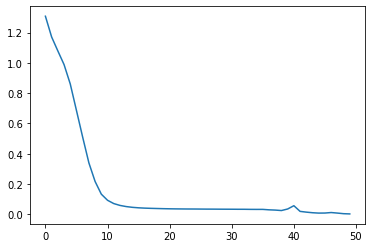

In [21]:
plot1 = plt.plot(history.history['loss'])